# **Multilayer Perceptron: Market Timing in AAPL Stock**

**Goal**: To design a strategy that times the return of Apple Stock using MLP network that aims to predict whether the future return of AAPL is positive or negtaive.

**1. Data**

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as ts

from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
df = yf.download("AAPL", start="1980-01-01", end="2022-04-11")

df["Ret"] = df["Close"].pct_change()
df.reset_index(inplace=True)
name = "Ret"
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Ret
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,
10415,2022-04-04,175.787811,175.837071,171.847264,171.975337,76468400,0.023693
10416,2022-04-05,172.458023,175.649871,171.827536,174.861759,73401800,-0.018942
10417,2022-04-06,169.276062,171.049311,167.601332,169.798183,89058800,-0.018451
10418,2022-04-07,169.581482,170.783350,167.325525,168.616052,77594700,0.001804
10419,2022-04-08,167.561905,169.226788,166.685134,169.226788,76575500,-0.011909


**Inputs and Outputs**

In [3]:
df["Ret25_i"] = df[name].rolling(25).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret60_i"] = df[name].rolling(60).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret90_i"] = df[name].rolling(90).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret120_i"] = df[name].rolling(120).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret240_i"] = df[name].rolling(240).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))

del df["Date"]
del df["Open"]
del df["Close"]
del df["High"]
del df["Low"]
del df["Volume"]

df = df.dropna()
df.tail(10)

Price,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i
Ticker,,,,,,
10410,0.005037,0.053177,-0.002813,0.168500,0.239295,0.300388
10411,0.019135,0.090150,0.019857,0.171149,0.252153,0.322116
10412,-0.006650,0.109387,-0.011795,0.135913,0.236380,0.310361
10413,-0.017776,0.074899,-0.016879,0.101120,0.221290,0.305399
10414,-0.001718,0.060206,0.008005,0.096470,0.220199,0.300737
10415,0.023693,0.082274,0.048402,0.117761,0.253071,0.336226
10416,-0.018942,0.074953,0.028462,0.095510,0.238331,0.299128
10417,-0.018451,0.035893,0.009890,0.108755,0.199571,0.277636
10418,0.001804,0.039680,-0.005089,0.088668,0.193851,0.281902


**Defining the output: Classification**

- Defining output labels with the focus on the +120(trading) days return for Apple stock. The aim is to predict whether, on a given time t, the return of AAPL from time t to t+120 days will be positive or negative - zero return, although unlikely, will also be classified as a negative return.
- Therefore, we first investigate, at a given time t, what would be the 120-day return. Then, we calculate our output variable, keeping in that we'll be running a classifcation task, and, hence, we need to convert our output variables to a 0, 1, variable (0 for negative 120 days return, and 1 for positive).

In [4]:
df["Ret120"] = df["Ret120_i"].shift(-120)
df["Output"] = df["Ret120"] > 0
df["Output"] = df["Output"].astype(int)
del df["Ret120"]
df = df.dropna()
df.tail()

<ipython-input-4-fb0682996e35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ret120"] = df["Ret120_i"].shift(-120)
<ipython-input-4-fb0682996e35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Output"] = df["Ret120"] > 0
<ipython-input-4-fb0682996e35>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Price,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
Ticker,,,,,,,
10415,0.023693,0.082274,0.048402,0.117761,0.253071,0.336226,0
10416,-0.018942,0.074953,0.028462,0.095510,0.238331,0.299128,0
10417,-0.018451,0.035893,0.009890,0.108755,0.199571,0.277636,0
10418,0.001804,0.039680,-0.005089,0.088668,0.193851,0.281902,0
10419,-0.011909,0.046183,-0.019567,0.045156,0.170093,0.276003,0


In [5]:
df.describe()

Price,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
Ticker,,,,,,,
count,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000
mean,0.001180,0.029372,0.070766,0.105697,0.139707,0.275046,0.704322
std,0.028192,0.141406,0.226664,0.279427,0.321383,0.447276,0.456369
min,-0.518692,-0.940299,-1.151644,-1.040123,-1.048317,-0.902589,0.000000
25%,-0.012824,-0.048530,-0.048529,-0.045875,-0.043797,-0.048385,0.000000
50%,0.000000,0.035273,0.083604,0.120599,0.159032,0.294689,1.000000
75%,0.014601,0.115022,0.210867,0.265228,0.315018,0.565963,1.000000
max,0.332281,0.882472,0.892261,1.141607,1.301160,1.782617,1.000000


**2. Train-Test Samples and Scaling**

- We will take 20% of observations and devote them to testing, while 80% will be used for training the model

In [6]:
ts = int(0.2 * len(df)) # Number of observations in the test sample
split_time = len(df) - ts  # From this data we are in the test sample
test_time = df.iloc[split_time:, 0:1].values  # Keep the test sample dates
Ret_vector = df.iloc[split_time:, 1:2].values
df.tail()

Price,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
Ticker,,,,,,,
10415,0.023693,0.082274,0.048402,0.117761,0.253071,0.336226,0
10416,-0.018942,0.074953,0.028462,0.095510,0.238331,0.299128,0
10417,-0.018451,0.035893,0.009890,0.108755,0.199571,0.277636,0
10418,0.001804,0.039680,-0.005089,0.088668,0.193851,0.281902,0
10419,-0.011909,0.046183,-0.019567,0.045156,0.170093,0.276003,0


- Next, we use sklearn to formally define the input and output matrices for training (X_train and y_train) and test (X_test and y_test).

In [7]:
Xdf, ydf = df.iloc[:, 2:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, shuffle=True
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8144, 4) (2036, 4) (8144,) (2036,)


**2. Model Training**

**Scaling**: We use scaled data by taking prices that adjust for any dividends.

**Model and Training**: We use 3 hidden layers with 25, 15, 10 units respectively, and a final single-unit output layer.
- All hidden layers use a ReLU activation function, whereas the output layer uses sigmoid activation function.
- **Dropou Layer** - after each hidden layer. Dropout randomly sets some units of a hidden layer to zero. We set n_dropout = 0.2 to shut down 20% of the units in the layer.
- **Loss function**  We use a binary cross-entropy that is essentially a log-likelihood.

![image.png](attachment:image.png)

- **Metric for loss function** - Binary accuracy.

In [8]:
tf.keras.backend.clear_session() # We clear the backend to reset the random seed process
tf.random.set_seed(1234) # A random seed so that results obtained are somewhat replicable.

act_fun = 'relu'
hp_units = 25
hp_units_2 = 15
hp_units_3 = 10
n_dropout = 0.2

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

hp_lr = 1e-5 # learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

**4. Validation and callbacks (Earlystopping)**

In [9]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="Val_accuracy",
    mode="max",
    verbose="1",
    patience=20,
    restore_best_weights=True,
)

**Classification on imbalance data: class_weight**

- There's always a possibility that one of the labels we are trying to predict is underrepresented in the training sample.
- Ideally you would want the model to give a heavier weight to underrepresented labels so that you do not overlook this in future prediction.
- **class_weights** - essentially consist on passing keras a weight for each class in the sample, so that we can make the model focus on a particular class more than it will be based on its representation in the sample.

In [10]:
class_weight = {0: (np.mean(y_train) / 0.5) * 1.2, 1: 1.0}
print(class_weight)

{0: 1.691257381439209, 1: 1.0}


- Finally, we train the model:

In [11]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    verbose=2,
    callbacks=[es],
    class_weight=class_weight,
)

Epoch 1/500
204/204 - 5s - 26ms/step - accuracy: 0.4072 - loss: 0.8538 - val_accuracy: 0.4070 - val_loss: 0.7124
Epoch 2/500


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `Val_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


204/204 - 2s - 10ms/step - accuracy: 0.4305 - loss: 0.8472 - val_accuracy: 0.4242 - val_loss: 0.7073
Epoch 3/500
204/204 - 1s - 6ms/step - accuracy: 0.4507 - loss: 0.8449 - val_accuracy: 0.4592 - val_loss: 0.7023
Epoch 4/500
204/204 - 1s - 7ms/step - accuracy: 0.4783 - loss: 0.8404 - val_accuracy: 0.4905 - val_loss: 0.6979
Epoch 5/500
204/204 - 2s - 11ms/step - accuracy: 0.4970 - loss: 0.8406 - val_accuracy: 0.5261 - val_loss: 0.6938
Epoch 6/500
204/204 - 1s - 4ms/step - accuracy: 0.5179 - loss: 0.8371 - val_accuracy: 0.5599 - val_loss: 0.6903
Epoch 7/500
204/204 - 1s - 6ms/step - accuracy: 0.5318 - loss: 0.8342 - val_accuracy: 0.6041 - val_loss: 0.6871
Epoch 8/500
204/204 - 1s - 6ms/step - accuracy: 0.5510 - loss: 0.8315 - val_accuracy: 0.6292 - val_loss: 0.6845
Epoch 9/500
204/204 - 1s - 7ms/step - accuracy: 0.5699 - loss: 0.8315 - val_accuracy: 0.6532 - val_loss: 0.6822
Epoch 10/500
204/204 - 1s - 6ms/step - accuracy: 0.5665 - loss: 0.8309 - val_accuracy: 0.6667 - val_loss: 0.6800
E

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 25)                  │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,060 (8.05 KB)

 Trainable params: 686 (2.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,374 (5.37 KB)

**5. Financial Performance of the model**

In [16]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.5, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7085 - loss: 0.6202
Model accuracy in test:  [0.6190775632858276, 0.7077603340148926]


The confusion matrix:

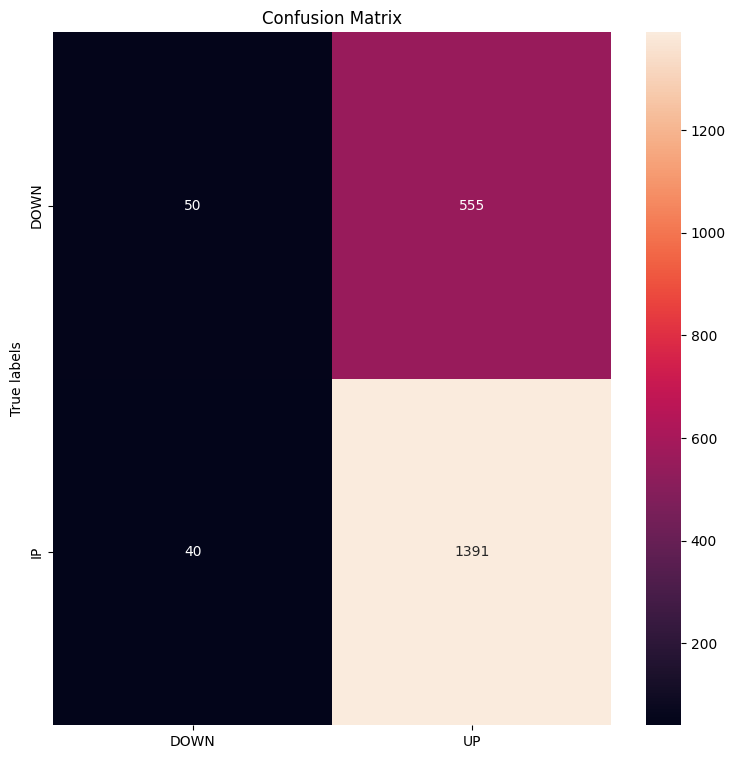

In [19]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)

ax.set_label("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["DOWN", "UP"])
ax.yaxis.set_ticklabels(["DOWN", "IP"]);

**Trading Strategy based on Moddel Predictions**

- We use backtesting strategy.

In [20]:
df_predictions = pd.DataFrame(
    {
        "Date": test_time.flatten(),
        "Pred": y_pred.flatten(),
        "Ret": Ret_vector.flatten(),
    }
)

df_predictions.tail()

,Date,Pred,Ret
2031,0.023693,1,0.082274
2032,-0.018942,1,0.074953
2033,-0.018451,0,0.035893
2034,0.001804,1,0.039680
2035,-0.011909,1,0.046183


In [21]:
df_predictions.Date = pd.to_datetime(df_predictions.Date)
df = df_predictions
df.tail()

,Date,Pred,Ret
2031,1970-01-01,1,0.082274
2032,1970-01-01,1,0.074953
2033,1970-01-01,0,0.035893
2034,1970-01-01,1,0.039680
2035,1970-01-01,1,0.046183


The trading strategy will take long(+1) if the prediction of the model is higher than 0.5, and short(-1) if less. We'll backtest 3 trading strategies:
- A long/short strategy that will take a long or short position when model prediction indcates so.
- a long-only strategy that will go to cash(return = 0) when the model predicts a negative 120-day return.
- A Buy-and-hold strategy that will buy the stock at the beginning of the test period and hold it until the end of the period.

In [22]:
df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-22-e31b33566a32>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Positions_L"][df["Positions_L"] == -1] = 0
<ipython-input-22-e31b33566a32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Strat Return Long Only = 8.733945350461736e+25 %
Strat Return = 5.636476649246769e+24 %
Buy and Hold Return = 7.272880418839135e+26 %


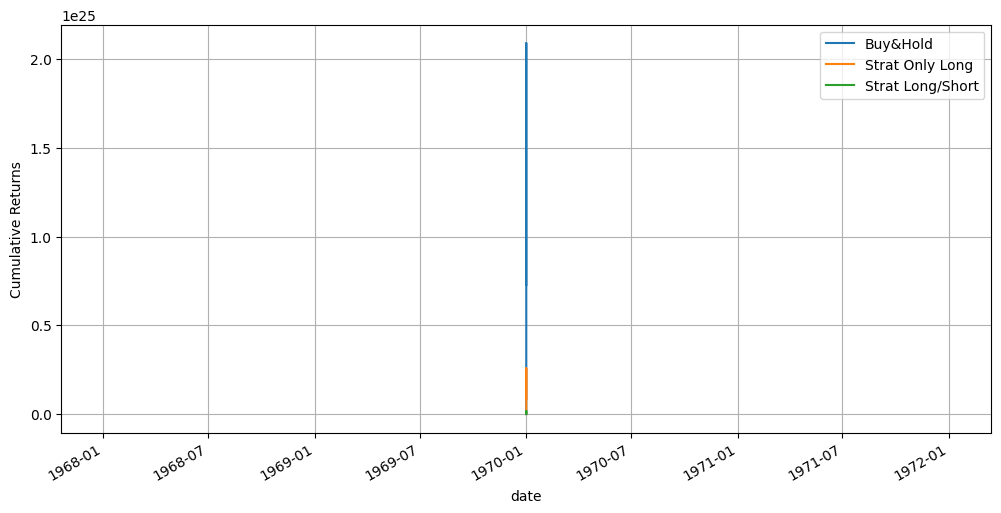

,Date,Pred,Ret,Positions,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet
count,2036,2036.000000,2036.000000,2036.000000,2035.000000,2035.000000,2035.000000,2.035000e+03,2.035000e+03,2.036000e+03
mean,1970-01-01 00:00:00,0.955796,0.032177,0.911591,0.029808,0.955774,0.030985,3.614960e+21,5.103542e+22,3.941167e+23
min,1970-01-01 00:00:00,0.000000,-0.328343,-1.000000,-0.328343,0.000000,-0.328343,3.581063e-02,3.581063e-02,6.037083e-02
25%,1970-01-01 00:00:00,1.000000,-0.017585,1.000000,-0.022179,1.000000,-0.015095,1.059753e+04,2.965510e+04,7.376210e+04
50%,1970-01-01 00:00:00,1.000000,0.039347,1.000000,0.035893,1.000000,0.033694,7.159112e+08,1.741032e+09,3.481256e+09
75%,1970-01-01 00:00:00,1.000000,0.091600,1.000000,0.090704,1.000000,0.089715,1.493546e+14,1.204673e+15,5.850207e+15
max,1970-01-01 00:00:00,1.000000,0.377267,1.000000,0.377267,1.000000,0.377267,1.730503e+23,2.575082e+24,2.089577e+25
std,NaN,0.205599,0.085488,0.411199,0.086357,0.205647,0.083999,1.790907e+22,2.620825e+23,2.077926e+24


In [23]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df.describe()